In [1]:
import pandas as pd
import numpy as np
import xarray as xr
import math
import matplotlib.pyplot as plt

data = xr.open_dataset("data/delhi_cpcb_2022.nc")
# data = xr.open_dataset("delhi_cpcb_2022.nc")
data

<xarray.Dataset>
Dimensions:    (station: 40, time: 8783)
Coordinates:
  * station    (station) object 'Alipur, Delhi - DPCC' ... 'Wazirpur, Delhi -...
  * time       (time) datetime64[ns] 2022-01-01T00:30:00 ... 2023-01-01T22:23:30
    latitude   (station) float64 ...
    longitude  (station) float64 ...
Data variables: (12/21)
    From Date  (station, time) datetime64[ns] ...
    To Date    (station, time) datetime64[ns] ...
    PM2.5      (station, time) float64 ...
    PM10       (station, time) float64 ...
    NO         (station, time) float64 ...
    NO2        (station, time) float64 ...
    ...         ...
    WD         (station, time) float64 ...
    SR         (station, time) float64 ...
    BP         (station, time) float64 ...
    AT         (station, time) float64 ...
    RF         (station, time) float64 ...
    TOT-RF     (station, time) float64 ...

In [2]:
df = data.to_dataframe().reset_index()
df = df[df["time"]=="2022-01-01 00:30:00"]
df = df.dropna(subset=["PM2.5"])
df = df.rename(columns={"RH": "relative_humidity", "WS": "wind_speed", "WD": "wind_direction", "SR": "solar_radiation", "BP": "pressure", "AT": "temperature", "RF": "rain_fall", "TOT-RF": "total_rainfall"})

In [3]:
lat_list = [28.815329,28.647622,28.695381,28.4706914,28.7762,28.7256504,28.5512005,28.656756,28.7500499,28.498571,28.5710274,28.655935,28.5627763,28.6811736,28.628624,28.73282,28.58028,28.588333,28.5918245,28.611281,28.636429,28.684678,28.60909,28.570173,28.822836,28.56789,28.6573814,28.530785,28.623763,28.674045,28.639645,28.639645,28.563262,28.732528,28.6514781,28.5504249,28.710508,28.531346,28.672342,28.699793]

In [4]:
df.head()

,station,time,From Date,To Date,PM2.5,PM10,NO,NO2,NOx,NH3,...,relative_humidity,wind_speed,wind_direction,solar_radiation,pressure,temperature,rain_fall,total_rainfall,latitude,longitude
0,"Alipur, Delhi - DPCC",2022-01-01 00:30:00,2022-01-01,2022-01-01 01:00:00,219.50,342.75,94.73,53.95,105.95,3.78,...,79.75,NaN,205.95,4.60,999.10,6.85,0.0,0.0,28.815329,77.153010
8783,"Anand Vihar, Delhi - DPCC",2022-01-01 00:30:00,2022-01-01,2022-01-01 01:00:00,613.25,NaN,406.70,104.50,387.18,30.10,...,84.15,0.30,173.00,8.95,974.98,11.95,NaN,0.0,28.647622,77.315809
17566,"Ashok Vihar, Delhi - DPCC",2022-01-01 00:30:00,2022-01-01,2022-01-01 01:00:00,428.75,533.50,137.55,46.52,136.90,45.27,...,90.15,0.25,112.43,6.03,993.50,10.17,0.0,0.0,28.695381,77.181665
26349,"Aya Nagar, Delhi - IMD",2022-01-01 00:30:00,2022-01-01,2022-01-01 01:00:00,147.12,254.39,21.02,33.68,54.69,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,28.470691,77.109936
35132,"Bawana, Delhi - DPCC",2022-01-01 00:30:00,2022-01-01,2022-01-01 01:00:00,300.00,452.00,69.28,16.77,86.20,63.47,...,83.62,0.40,178.80,5.60,998.92,7.77,0.0,0.0,28.776200,77.051074


In [5]:
import networkx as nx
import math

# Define the distance threshold for G1 (in kilometers)
distance_threshold_1 = 100 #for creating fully connected graph

G1 = nx.Graph()

# Iterate through each node in the dataset
for i in range(len(df)):
    lat1, lon1 = df.iloc[i]['latitude'], df.iloc[i]['longitude']
    pm = df.iloc[i]['PM2.5']
    
    # Add the current node to the nx graph
    G1.add_node(i, latitude=lat1, longitude=lon1, pm=pm)

    # Iterate through the remaining nodes
    for j in range(i + 1, len(df)):
        lat2, lon2 = df.iloc[j]['latitude'], df.iloc[j]['longitude']
        
        # Calculate the distance between the coordinates using the Haversine formula
        radius = 6371  # Earth's radius in kilometers
        dlat = math.radians(lat2 - lat1)
        dlon = math.radians(lon2 - lon1)
        a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        distance = radius * c
        
        # Check if the distance is below the threshold
        if distance <= distance_threshold_1:
            # Add an edge between the current pair of nodes in the nx graph
            G1.add_edge(i, j, weight = 1/distance)

# Now you have the nx graph where nodes represent the data points with latitude and longitude as features, and edges represent nodes within the distance threshold

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset

#G1
node_features = [(G1.nodes[node]['latitude'], G1.nodes[node]['longitude']) for node in G1.nodes]
edge_index = torch.tensor(list(G1.edges)).t().contiguous()
edge_weights = torch.tensor(list(nx.get_edge_attributes(G1, "weight").values())).contiguous()
# adj = torch.tensor(adj_mat).t().contiguous()
y = torch.tensor([G1.nodes[node]['pm'] for node in G1.nodes], dtype=torch.float).view(-1, 1)
sorted_nodes = sorted(G1.nodes(), key=lambda node: G1.nodes[node]['latitude'])

# Divide train and test masks based on the sorted latitudes
train_mask = torch.zeros(y.size(0), dtype=torch.bool)
test_mask = torch.zeros(y.size(0), dtype=torch.bool)

for i, node in enumerate(G1.nodes):
    lat = G1.nodes[node]['latitude']
    if lat in lat_list[:30]:
        train_mask[i] = True
    else:
        test_mask[i] = True


data1 = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index, edge_weight = edge_weights, y=y,train_mask=train_mask, test_mask=test_mask)

In [7]:
from torch_geometric.nn import GCNConv, GATConv, SAGEConv

class RegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(RegressionModel, self).__init__()
        self.conv1 = GCNConv(input_dim, 16)
        self.conv2 = GCNConv(16, 10)
        self.linear1 = nn.Linear(10, 10)
        self.linear2 = nn.Linear(10, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = self.linear1(x)
        x = F.relu(x)
        x = self.linear2(x)
        return x


In [8]:
import random
seed = 42
random.seed(seed)
torch.manual_seed(seed)


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model1 = RegressionModel(input_dim=2).to(device)
optimizer = torch.optim.Adam(model1.parameters(), lr=0.01)
criterion = nn.MSELoss()

In [9]:
train_rmse_list1 = []
test_rmse_list1 = []
model1

RegressionModel(
  (conv1): GCNConv(2, 16)
  (conv2): GCNConv(16, 10)
  (linear1): Linear(in_features=10, out_features=10, bias=True)
  (linear2): Linear(in_features=10, out_features=1, bias=True)
)

In [10]:
from tqdm import tqdm

#Training Loop for G1
for epoch in tqdm(range(2500)):
    optimizer.zero_grad()
    out = model1(data1.x.to(device), data1.edge_index.to(device))
    loss = criterion(out[data1.train_mask].squeeze(), data1.y[data1.train_mask].squeeze())
    loss.backward()
    optimizer.step()
    if(epoch%100==0):
        model1.eval()
        with torch.no_grad():
            out = model1(data1.x.to(device), data1.edge_index.to(device))  # Predicted PM values
            train_rmse = torch.sqrt(torch.mean((out[data1.train_mask].squeeze() - data1.y[data1.train_mask].squeeze())**2))
            test_rmse = torch.sqrt(torch.mean((out[data1.test_mask].squeeze() - data1.y[data1.test_mask].squeeze())**2))
            train_rmse_list1.append(train_rmse.item())
            test_rmse_list1.append(test_rmse.item())
        model1.train()

100%|█████████████████████████████████████████████████████████████████████████████| 2500/2500 [00:06<00:00, 365.46it/s]


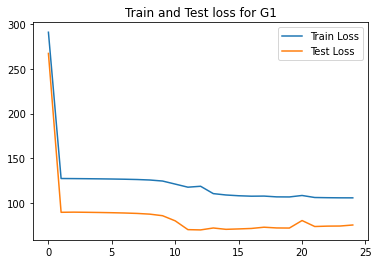

In [11]:
import matplotlib.pyplot as plt

# Assuming you have train_loss_list and test_loss_list as lists containing the respective losses

# Plotting train loss
plt.plot(range(len(train_rmse_list1)), train_rmse_list1, label='Train Loss')

# Plotting test loss
plt.plot(range(len(test_rmse_list1)), test_rmse_list1, label='Test Loss')
plt.title("Train and Test loss for G1")
plt.legend()
plt.show()

In [12]:
model1.eval()
with torch.no_grad():
    out = model1(data1.x.to(device), data1.edge_index.to(device))  # Predicted PM values
    train_rmse = torch.sqrt(torch.mean((out[data1.train_mask].squeeze() - data1.y[data1.train_mask].squeeze())**2))
    test_rmse = torch.sqrt(torch.mean((out[data1.test_mask].squeeze() - data1.y[data1.test_mask].squeeze())**2))
    print("G1")
    print(f"GNN train rmse:{train_rmse}")
    print(f"GNN test rmse: {test_rmse}")

G1
GNN train rmse:105.3006591796875
GNN test rmse: 75.33744812011719


In [13]:
#Create points for Heatmap
latitudes = np.array(df['latitude'])
longitudes = np.array(df['longitude'])
g_lat = np.linspace(latitudes.min()-0.1, latitudes.max()+0.1, 30)
g_long = np.linspace(longitudes.min()-0.1, longitudes.max()+0.1, 30)
lat_grid, lon_grid = np.meshgrid(g_lat, g_long)

#generate df of points for heatmap
test = pd.DataFrame({'longitude':lon_grid.flatten(),
                 'latitude':lat_grid.flatten()})

In [14]:
import networkx as nx
import math

distance_threshold_1 = 100

Gh = nx.Graph()

for i in range(len(test)):
    lat1, lon1 = test.iloc[i]['latitude'], test.iloc[i]['longitude']
    
    # Add the current node to the nx graph
    Gh.add_node(i, latitude=lat1, longitude=lon1)

    # Iterate through the remaining nodes
    for j in range(i + 1, len(test)):
        lat2, lon2 = test.iloc[j]['latitude'], test.iloc[j]['longitude']
        
        # Calculate the distance between the coordinates using the Haversine formula
        radius = 6371  # Earth's radius in kilometers
        dlat = math.radians(lat2 - lat1)
        dlon = math.radians(lon2 - lon1)
        a = math.sin(dlat/2) * math.sin(dlat/2) + math.cos(math.radians(lat1)) * math.cos(math.radians(lat2)) * math.sin(dlon/2) * math.sin(dlon/2)
        c = 2 * math.atan2(math.sqrt(a), math.sqrt(1-a))
        distance = radius * c
        
        # Check if the distance is below the threshold
        if distance <= distance_threshold_1:
            # Add an edge between the current pair of nodes in the nx graph
            Gh.add_edge(i, j)

# Now you have the nx graph where nodes represent the data points with latitude and longitude as features, and edges represent nodes within the distance threshold

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.data import Data, Dataset

#Gh
node_features = [(Gh.nodes[node]['latitude'], Gh.nodes[node]['longitude']) for node in Gh.nodes]
edge_index = torch.tensor(list(Gh.edges)).t().contiguous()

data_h = Data(x=torch.tensor(node_features, dtype=torch.float), edge_index=edge_index)

In [16]:
out = model1(data_h.x.to(device), data_h.edge_index.to(device))
test['PM2.5'] = out.detach().numpy()

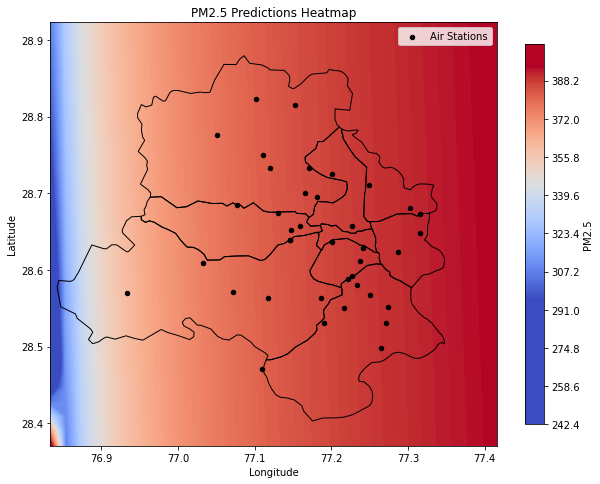

In [17]:
import heatmap
heatmap.plot_heatmap(lon = np.array(test['longitude']), lat = np.array(test['latitude']), values = test['PM2.5'].values)

(array([  1.,   1.,   0.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,   1.,
          2.,   1.,   2.,   1.,   2.,   2.,   2.,   2.,   4.,   2.,   3.,
          4.,   3.,   4.,   5.,   5.,   6.,   8.,   7.,   9.,   9.,  11.,
         13.,  15.,  17.,  20.,  24.,  28.,  35.,  41.,  49.,  61.,  76.,
         95., 122., 158.,  41.,   0.,   1.]),
 array([242.81950378, 246.03289795, 249.24629211, 252.45970154,
        255.6730957 , 258.88650513, 262.09988403, 265.31329346,
        268.52667236, 271.74008179, 274.95349121, 278.16687012,
        281.38027954, 284.59365845, 287.80706787, 291.02047729,
        294.2338562 , 297.44726562, 300.66064453, 303.87405396,
        307.08746338, 310.30084229, 313.51425171, 316.72766113,
        319.94104004, 323.15444946, 326.36782837, 329.58123779,
        332.79464722, 336.00802612, 339.22143555, 342.43481445,
        345.64822388, 348.8616333 , 352.07501221, 355.28842163,
        358.50180054, 361.71520996, 364.92861938, 368.14199829,
        371.355407

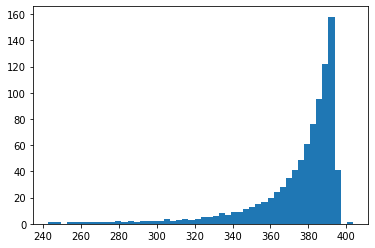

In [18]:
plt.hist(test['PM2.5'], bins = 50)